# LLM Example

In [6]:
import datasets
import numpy as np
# import hyped components
from hyped.data.flow.processors.templates.jinja2 import Jinja2
from hyped.data.flow.processors.api.openai_chat import OpenAIChatCompletion
from hyped.data.flow.processors.parsers.json import JsonParser
from hyped.data.flow.ops import collect
from hyped.data.flow.flow import DataFlow
# import matplotlib
import matplotlib.pyplot as plt
# load openai key from .env file
from dotenv import load_dotenv

datasets.disable_caching()
load_dotenv()

True

In [7]:
ds = datasets.load_dataset("stanfordnlp/imdb", split="test")
ds = ds.select(np.random.choice(len(ds), 10))
ds

Dataset({
    features: ['text', 'label'],
    num_rows: 10
})

In [36]:
flow = DataFlow(ds.features)

In [37]:
template = Jinja2(template="Classify the following excerpt: {{ inputs.text }}")
template_out = template.call(features=flow.src_features)

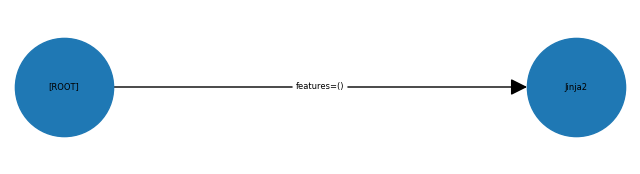

In [38]:
plt.figure(figsize=(8, 2))
flow.plot(ax=plt.gca());

In [39]:
system_prompt = (
    "Given text excerpts from IMDb movie review, your task is to predict "
    "whether each review is positive or negative. Your output should be a "
    "json string of the following format: {\"label\": <LABEL>} where "
    "<LABEL> is either \"positive\" or \"negative\"."
)

In [40]:
llm = OpenAIChatCompletion(
    model="gpt-3.5-turbo-0125",
    response_format={"type": "json_object"},
)
llm_out = llm.call(
    messages=collect([
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": template_out.rendered,
        },
    ])
)

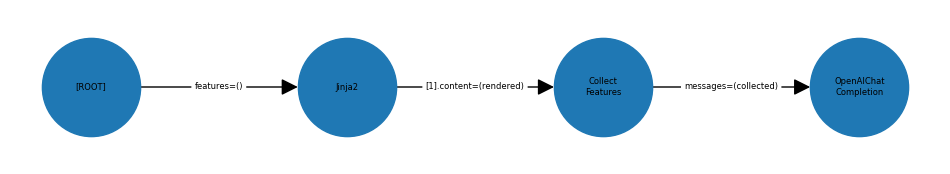

In [41]:
plt.figure(figsize=(12, 2))
flow.plot(ax=plt.gca());

In [42]:
parser = JsonParser(
    scheme=datasets.Features({
        "label": datasets.ClassLabel(names=["negative", "positive"])
    })
)
parser_out = parser.call(json_str=llm_out.message)

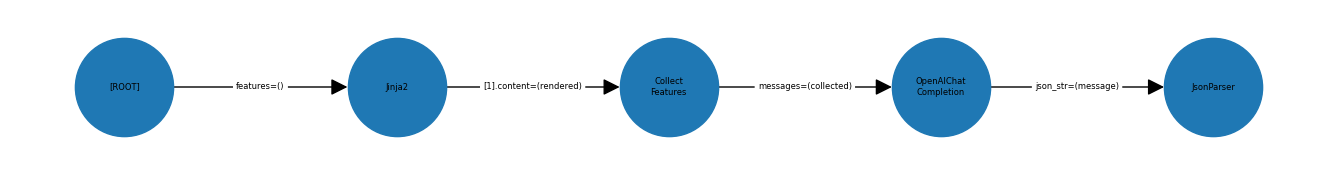

In [43]:
plt.figure(figsize=(17, 2))
flow.plot(ax=plt.gca());

In [44]:
output_features = collect({
    "label": flow.src_features.label,
    "pred": parser_out.parsed.label,
})

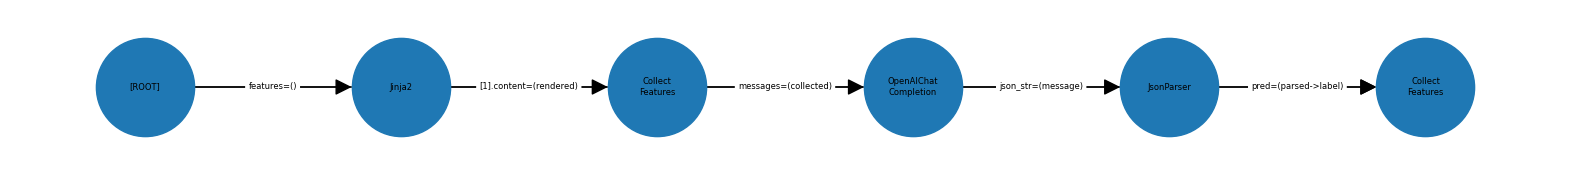

In [46]:
plt.figure(figsize=(20, 2))
flow.plot(ax=plt.gca());

In [47]:
# apply pipeline to dataset
out_ds = flow.apply(ds, collect=output_features)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [48]:
preds = np.asarray(out_ds["pred"])
trues = np.asarray(out_ds["label"])
# compute accuracy
(preds == trues).astype(float).mean()

0.7